# Pin Estimation on BTCUSDP

In [ ]:
!pip install nb_black
!pip install google-cloud-bigquery --upgrade
!pip install gcsfs
! pip install db-dtypes

In [1]:
import sys
import os
import logging

from datetime import datetime, timezone, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize

sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

sys.path.append("/home/jovyan/research/research_utils/helpers")
from GCData import GCData
from Candle import get_candle



### BTCUSDP Raw Trade Data

In [2]:
trade_data = GCData(
    datatype="trades",
    exchange="ftx",
    symbol="BTCUSDP",
    end = datetime.strptime("2022-6-2","%Y-%m-%d"),
    start= datetime.strptime("2022-6-1","%Y-%m-%d")
)
trades = trade_data.get_data()
trades.to_csv('/home/jovyan/HFT_Research/PIN_Research/data/daily_trade.csv')

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
trades

,side,size,price,value
time,,,,
2022-06-01 00:00:01.118011+00:00,True,0.0394,31782.0,1252.2108
2022-06-01 00:00:02.881145+00:00,False,0.0011,31781.0,34.9591
2022-06-01 00:00:04.037885+00:00,True,0.5809,31782.0,18462.1638
2022-06-01 00:00:04.368036+00:00,True,3.5788,31785.0,113752.1580
2022-06-01 00:00:04.393108+00:00,False,0.7000,31784.0,22248.8000
...,...,...,...,...
2022-06-01 23:59:59.690584+00:00,True,0.3708,29783.0,11043.5364
2022-06-01 23:59:59.765580+00:00,True,0.2000,29784.0,5956.8000
2022-06-01 23:59:59.766171+00:00,True,0.2000,29784.0,5956.8000


### Aggregate the number of buys and sells in each minute 

In [4]:
counts=(trades.groupby('side').resample('1min').count().sum(axis=1)/trades.shape[1]).reset_index().set_index('time')
buys=counts[counts['side']==False][0].values
sells=counts[counts['side']==True][0].values

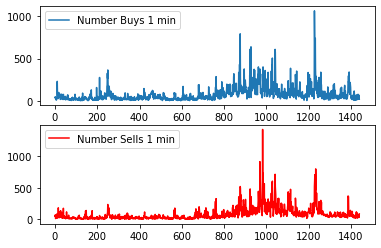

In [5]:
fig,ax=plt.subplots(2)
ax[0].plot(buys,label='Number Buys 1 min')
ax[1].plot(sells,color='r',label='Number Sells 1 min')
ax[0].legend()
ax[1].legend()

### Model Formulation

The Probability of Informed Trading is computed as $\frac{\alpha \mu}{\alpha \mu +\epsilon_B +\epsilon_S}$ where our vector of parameters are estimated from observed data. 

Note buy and sell orders are assumed to arrive according to a Poisson Process. $\alpha$ represents the probability of an information event while $\delta$ represents probability of positive information

The model framework assumes for each time point either an information event occurred or not. Based on this optimal value the arrival rates for uniformed buys and sells along with informed buys and sells can be optimized in the form of a mixture model (which is analytically tractable) 

The probability of informed trading gives us an estimate on the overall proportion of the market share that can be attributed to informed traders (that follow risk-neutral preferences)

### Initialization of Params 

In [6]:
# initialize parameters for PIN estimations
def init_params(B,S):
    B=B/100
    S=S/100
    alph = 0.1 # probability of information event
    delt = 0.25 # probability of good news 
    gamm = 0.5 # weighted ratio of order arrivals to informed orders 
    B_bar = np.average(B)
    epsiB = gamm*B_bar
    miu = (B_bar-epsiB)/(alph*(1-delt))
    epsiS = np.average(S)-alph*delt*miu
    return [alph,delt,miu,epsiB,epsiS]

### EHO Liklihood Model for estimation of Params

Provided a factorization of the log-liklihood to mitigate overflow values (factorials of standard binomial) where it is

$$\log[L(B,S)|\theta]=\sum_{i=1}^n {\log(\alpha(1-\delta)\exp^{-\mu}X_s^{S_i-M_i}x_b^{-M_i} +\alpha\delta\exp^{-\mu}X_s^{-M_i}x_b^{B_i-M_i}+(1-\alpha)\exp^{-\mu}X_s^{S_i-M_i}x_b^{B_i-M_i}}$$
$$ -(\epsilon_B+\epsilon_S)+M_i(\log X_b + \log X_s) +B_i(\log \mu +\epsilon_b)+S_i(\log \mu +\epsilon_s)$$

In [32]:
def pin_likelihood_EHO(params,B,S,fixed_params=False,alph=0.1,delt=0.5): 
    
    '''
    Compute EHO liklihood value given an input set of parameters using factorization approach from Easley, Hvidkjaer, and O’Hara (2010)
    
    This is an improvement of the original methodology 
    
    :param params: tuple, \alpha, \delta \mu, \epsilon_B, \epsilon_S 
    :param B: list, list of buy flow  quantity
    :param S: list, list of sell flow  quantity
    :return: float, joint likelihood function, the likelihood/ probability of the params given the buy and sell flow
 
    '''
    #initialize parameter values
    
    if fixed_params==True:
        miu,epsiB,epsiS = params
    else:
        alph,delt,miu,epsiB,epsiS = params
    
    #initialize likelihood
    likel = 0.0
    
    #assign number of trading periods
    trading_periods  = min(len(B),len(S))
    B = B/100
    S = S/100
    
    for j in range(1,trading_periods):
        #number of buy- and sell-trads for the trading day
        buy_s = B[j]
        sell_s =S[j]
        
        #compute values of interest for the log-likelihood function
        M  = min(buy_s,sell_s)+max(buy_s,sell_s)/2
        Xs = epsiS/(miu+epsiS)
        Xb = epsiB/(miu+epsiB)
        
        a1 = np.exp(-miu)
        a2 = Xs**(sell_s-M)
        a3 = Xb**(buy_s-M)
        a4 = Xs**(-M)
        a5 = Xb**(-M)
        
        part1 = -epsiB-epsiS+M*(np.log(Xb)+np.log(Xs))+buy_s*np.log(miu+epsiB)+sell_s*np.log(miu+epsiS)
        part2 = np.log(alph*(1-delt)*a1*a2*a5+alph*delt*a1*a3*a4+(1-alph)*a2*a3) # expected value of sum is sum of expected values 
        
        likel = likel+part1+part2

    likel *= -1
    return likel
            

### Set some initial values 

In [33]:
params = init_params(buys,sells)
print("Initial Probability of Information is" ,round(params[0],2))
print("Initial Probability of Good Information is" ,round(params[1],2))
print("Initial Change of Arrivals from Information" ,round(params[2],2))
print("Arrival of Buys" ,round(params[3],2))
print("Arrival of Sells",round(params[4],2))

Initial Probability of Information is 0.1
Initial Probability of Good Information is 0.25
Initial Change of Arrivals from Information 5.06
Arrival of Buys 0.38
Arrival of Sells 0.7


In [34]:
pin_likelihood_EHO(params[2:],buys,sells,True) # initial liklihood of initial params 

2895.4828887415

### Compute Optimzation Routine of liklihood function to reach optimal under the buy and sell order flow 

Here we perform optimization using a trust region routine with support for constraints which we impose on the probabilities and arrival rates

In [35]:
from scipy.optimize import Bounds
bounds = Bounds([0.01,0.01,0.01,0.01,0.01],[1,1,np.inf,np.inf,np.inf]) # set bounds on our optimization as we are working with probabilities 

In [40]:
opt= minimize(pin_likelihood_EHO,params,args = (buys,sells),method = 'trust-constr',bounds=bounds)
opt

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 295
      cg_stop_cond: 4
            constr: [array([0.02663029, 0.7755954 , 4.9870848 , 0.72498239, 0.73176555])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 14.891339778900146
               fun: 2709.5114588366278
              grad: array([-1.06811523e-03,  3.05175781e-04, -6.11932207e-06,  6.71386719e-04,
        7.93457031e-04])
               jac: [<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-2.95270538e-07,  1.35251033e-05, -5.88227110e-06,  2.27111794e-04,
        2.71769368e-04])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 660
              nhev: 0
               nit: 118
             niter: 118
           

In [41]:
params = opt.x
print("Optimal Probability of Information is" ,round(params[0],4))
print("Optimal Probability of Good Information is" ,round(params[1],2))
print("Optimal Arrival Rate of Informed Trades" ,round(params[2],2))
print("Optimal Arrival Rate of Uninformed Buys" ,round(params[3],2))
print("Optimal Arrival Rate of Uninformed Sells",round(params[4],2))

Optimal Probability of Information is 0.0266
Optimal Probability of Good Information is 0.78
Optimal Arrival Rate of Informed Trades 4.99
Optimal Arrival Rate of Uninformed Buys 0.72
Optimal Arrival Rate of Uninformed Sells 0.73


In [42]:
PIN_EHO= (params[0]*params[2])/(params[0]*params[2]+params[3]+params[4])
print("Probability of informed trading is",round(PIN_EHO,2))

Probability of informed trading is 0.08


### Fixed Alpha and Delta

In [43]:
from scipy.optimize import Bounds
bounds = Bounds([0.01,0.01,0.01],[np.inf,np.inf,np.inf]) # set bounds on our optimization as we are working with probabilities 

In [44]:
params=params[2:]
opt= minimize(pin_likelihood_EHO,params,args = (buys,sells,True),method = 'trust-constr',bounds=bounds)
opt

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 261
      cg_stop_cond: 2
            constr: [array([2.88274168, 0.6888705 , 0.70944899])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 7.171639442443848
               fun: 2745.756132032654
              grad: array([-4.23452136e-05, -4.27246094e-04,  0.00000000e+00])
               jac: [<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-3.77692970e-05, -1.34786038e-04, -9.61888090e-10])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 320
              nhev: 0
               nit: 121
             niter: 121
              njev: 80
        optimality: 0.00013478603819521795
            status: 2
           success: True
      

In [46]:
params = opt.x
print("Optimal Probability of Information is" ,round(0.1,4))
print("Optimal Probability of Good Information is" ,round(0.5,2))
print("Optimal Arrival Rate of Informed Trades" ,round(params[0],2))
print("Optimal Arrival Rate of Uninformed Buys" ,round(params[1],2))
print("Optimal Arrival Rate of Uninformed Sells",round(params[2],2))

Optimal Probability of Information is 0.1
Optimal Probability of Good Information is 0.5
Optimal Arrival Rate of Informed Trades 2.88
Optimal Arrival Rate of Uninformed Buys 0.69
Optimal Arrival Rate of Uninformed Sells 0.71


In [48]:
PIN_EHO= (0.1*params[0])/(0.1*params[0]+params[1]+params[2])
print("Probability of informed trading is",round(PIN_EHO,2))

Probability of informed trading is 0.17


### Daily Estimation 

In [84]:
data={}
# iterate over daily data 
for x in range (0,29):
    trade_data = GCData(
    datatype="trades",
    exchange="ftx",
    symbol="BTCUSDP",
    end = datetime.strptime(str("2022-6-"+str(x+2)),"%Y-%m-%d"),
    start= datetime.strptime(str("2022-6-"+str(x+1)),"%Y-%m-%d"))
    
    # fetch raw trade data 
    trades = trade_data.get_data()
    
    # count the number of buy and sell initiated orders in each minute 
    counts=(trades.groupby('side').resample('1min').count().sum(axis=1)/trades.shape[1]).reset_index().set_index('time')

    # split this data into  hourly segments 
    buys=np.array_split(counts[counts['side']==False][0].values,24)
    sells=np.array_split(counts[counts['side']==True][0].values,24)
    
    # iterate over hourly buy and sells     
    for j in range (0,24):

        data[24*x+j]=(buys[j],sells[j])

In [90]:
data[0]

(array([ 38.,  42.,  48.,  31.,  17.,  14.,  14.,   8.,  37.,  36.,  38.,
        230.,  88.,  38.,  24.,  50.,  84.,  38.,  99.,  62.,  48.,  55.,
         52.,  82.,  55.,  36.,  16.,  30.,  48.,  42.,  55.,  34.,  79.,
         29.,  18.,  34.,  41.,  38.,  16.,  15.,  76.,  50.,  20.,  25.,
         20.,  27.,  38.,  16.,  46.,  52.,  18.,  11.,  31.,  18.,  43.,
         27.,  25.,  30.,  17.,  14.]),
 array([ 51.,  61.,  71.,  13.,  18.,  64.,  41.,  33.,  48.,  32.,  16.,
         91.,  79.,  48.,  51.,  75., 182., 102.,  52.,  26.,  25.,  80.,
         43., 113., 122.,  37.,  35., 136.,  80.,  32.,  49.,  83.,  86.,
         22.,  36., 108.,  23.,  19.,  30.,  27., 175.,  54.,  26.,  49.,
         32.,  51.,  35.,  27.,  16.,  29.,  21.,   9.,  30.,  33.,  30.,
        118.,  41.,  34.,  31.,  19.]))

In [91]:
bounds = Bounds([0.01,0.01,0.01],[np.inf,np.inf,np.inf]) # set bounds on our optimization as we are working with probabilities 

params_time=np.array([])

for i in range(0,29*24):
    b,s=data[i]
    params = init_params(b,s)
    pin_likelihood_EHO(params,b,s) # initial liklihood of initial params 
    opt= minimize(pin_likelihood_EHO,params,args = (b,s),method = 'trust-constr',bounds=bounds).x
    params_time=np.append(params_time,opt)
params_time

<ipython-input-8-79a52f2856ae>:36: RuntimeWarning: invalid value encountered in double_scalars
  a2 = Xs**(sell_s-M)
<ipython-input-8-79a52f2856ae>:37: RuntimeWarning: invalid value encountered in double_scalars
  a3 = Xb**(buy_s-M)
<ipython-input-8-79a52f2856ae>:38: RuntimeWarning: invalid value encountered in double_scalars
  a4 = Xs**(-M)
<ipython-input-8-79a52f2856ae>:39: RuntimeWarning: invalid value encountered in double_scalars
  a5 = Xb**(-M)
<ipython-input-8-79a52f2856ae>:41: RuntimeWarning: invalid value encountered in log
  part1 = -epsiB-epsiS+M*(np.log(Xb)+np.log(Xs))+buy_s*np.log(miu+epsiB)+sell_s*np.log(miu+epsiS)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
<ipython

array([0.01263773, 0.47927602, 0.05305041, ..., 1.15861745, 0.46338829,
       0.44278059])

In [97]:
params_time=params_time.reshape(29*24,5)

In [101]:
p=pd.DataFrame(params_time,columns=['Alpha','Delta','Mu','Buy','Sell'])

p['prob']=p['Alpha']*p['Mu']/(p['Alpha']*p['Mu']+p['Buy']+p['Sell'])
p.to_csv('hourly_params.csv')

In [52]:
p=pd.read_csv('/home/jovyan/HFT_Research/PIN_Research/params/hourly_params.csv')

Text(0.5, 0, 'June')

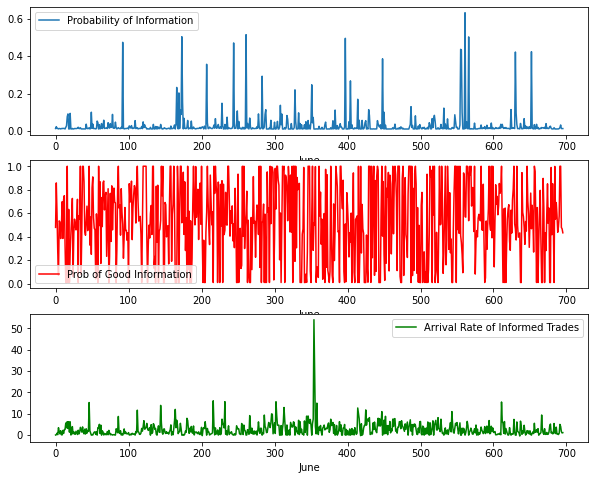

In [53]:
fig,ax=plt.subplots(3,figsize=(10,8))
ax[0].plot(p['Alpha'],label='Probability of Information')
ax[0].legend()
ax[0].set_xlabel('June')
ax[1].plot(p['Delta'],label='Prob of Good Information',color='red')
ax[1].legend()
ax[1].set_xlabel('June')
ax[2].plot(p['Mu'],label='Arrival Rate of Informed Trades',color='green')
ax[2].legend()
ax[2].set_xlabel('June')

Text(0.5, 0, 'June')

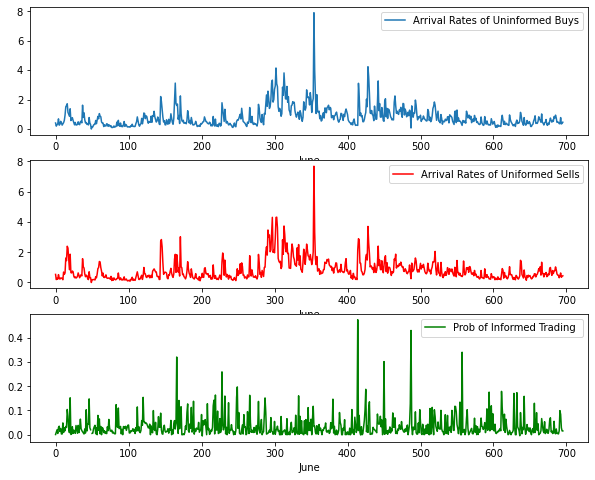

In [54]:
fig,ax=plt.subplots(3,figsize=(10,8))
ax[0].plot(p['Buy'],label='Arrival Rates of Uninformed Buys')
ax[0].legend()
ax[0].set_xlabel('June')
ax[1].plot(p['Sell'],label='Arrival Rates of Uniformed Sells',color='r')
ax[1].legend()
ax[1].set_xlabel('June')
ax[2].plot(p['prob'],label='Prob of Informed Trading ',color='green')
ax[2].legend()
ax[2].set_xlabel('June')

### Notes

- Arrival rates of uniformed buys and sells are equivalent (seem to be time-varying)
- Alpha is near identical we will set this as a constant as the mean of all values observed
- Likewise with delta 